### Loading the dataset containing the export data alongside with the nodal attribute available on each country

In [7]:
edges = read.csv('../datasets/wits/simulated/edgelist.csv')
nodes = read.csv('../datasets/wits/simulated/nodelist.csv')
# edges = read.csv('../datasets/wits/edgelist_2011.csv')
# nodes = read.csv('../datasets/wits/nodelist_2011.csv')
# nodes = read.csv('../datasets/wits/nl_no_missing.csv')
# edges = read.csv('../datasets/wits/el_no_missing.csv')

In [8]:
n = dim(nodes)[1]
N = 1000
country_names = nodes$country_iso3
nodes = transform(nodes, landlocked=as.logical(landlocked))

### Importing the library required for doing permutation tests

In [9]:
library(coin)
library(sna)
library(ergm)

In [10]:
head(nodes, 3)

,country_iso3,merchandise_of_gdp,area,population,industry_of_gdp,continent,agriculture_forestry_fishing_of_gdp,life_expectancy,landlocked,colonizer,net_barter_of_trade,inflation_rate,langoff_1,gni_atlas,foreign_direct_investment_inflows,happiness,gdp_us_dollar,gdp_growth,gdp_per_capita
,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,38.70415,652225,30117411,22.74025,Asia,23.743664,61.553,TRUE,USA,144.7519,11.804186,Persian,16077121256,52173421,0.721,17804292964,0.4263548,591.1628
2,AGO,78.30597,1246700,24220660,56.02651,Africa,5.845681,56.330,FALSE,PRT,244.3292,13.482468,Portuguese,82606027251,-3023770966,0.708,111789686464,3.4719763,4615.4682
3,ALB,56.86241,28748,2905195,24.48441,Europe,18.226765,76.914,FALSE,NONE,94.3372,3.429123,Albanian,12803715190,1048706682,0.568,12890765324,2.5453218,4437.1429


In [11]:
head(edges, 3)

,source,target,weight
,<chr>,<chr>,<dbl>
1,AFG,TKM,0.189
2,AGO,JPN,1369.367
3,AGO,BEN,1700.981


In [40]:
net = network(edges, directed = TRUE, matrix.type = 'edgelist')
set.vertex.attribute(x = net, attrname = colnames(nodes), value = nodes)
net

 Network attributes:
  vertices = 141 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 2874 
    missing edges= 0 
    non-missing edges= 2874 

 Vertex attribute names: 
    agriculture_forestry_fishing_of_gdp area colonizer continent country_iso3 foreign_direct_investment_inflows gdp_growth gdp_per_capita gdp_us_dollar gni_atlas happiness industry_of_gdp inflation_rate landlocked langoff_1 life_expectancy merchandise_of_gdp net_barter_of_trade population vertex.names 

 Edge attribute names not shown 

### Generating the adjacency matrix of the export network and the total Export/Import of all countries

In [41]:
countries_export_import = data.frame(
    country = c(nodes$country_iso3), 
    exports = matrix(0, nrow =n , ncol = 1),
    imports = matrix(0, nrow =n , ncol = 1)
)

In [42]:
for (i in 1:n) {
    countries_export_import[i, 2:3] = c(
        sum(edges$weight[edges$source == countries_export_import$country[i]]), 
        sum(edges$weight[edges$target == countries_export_import$country[i]])
    )
}

In [43]:
head(countries_export_import, 3)

,country,exports,imports
,<chr>,<dbl>,<dbl>
1,AFG,0.189,4417.172
2,AGO,4909.832,4013.016
3,ALB,425.820,13925.990


In [44]:
nodes$exports = countries_export_import$exports
nodes$imports = countries_export_import$imports

In [45]:
head(nodes, 3)

,country_iso3,merchandise_of_gdp,area,population,industry_of_gdp,continent,agriculture_forestry_fishing_of_gdp,life_expectancy,landlocked,colonizer,⋯,inflation_rate,langoff_1,gni_atlas,foreign_direct_investment_inflows,happiness,gdp_us_dollar,gdp_growth,gdp_per_capita,exports,imports
,<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,38.70415,652225,30117411,22.74025,Asia,23.743664,61.553,TRUE,USA,⋯,11.804186,Persian,16077121256,52173421,0.721,17804292964,0.4263548,591.1628,0.189,4417.172
2,AGO,78.30597,1246700,24220660,56.02651,Africa,5.845681,56.330,FALSE,PRT,⋯,13.482468,Portuguese,82606027251,-3023770966,0.708,111789686464,3.4719763,4615.4682,4909.832,4013.016
3,ALB,56.86241,28748,2905195,24.48441,Europe,18.226765,76.914,FALSE,NONE,⋯,3.429123,Albanian,12803715190,1048706682,0.568,12890765324,2.5453218,4437.1429,425.820,13925.990


In [46]:
adj_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(edges$source == country_names[i] & edges$target == country_names[j]) > 0) {
            adj_matrix[i, j] = edges$weight[edges$source == country_names[i] & edges$target == country_names[j]]
        }
    }
}
diag(adj_matrix) = 0

### Loading the dataset of distances between countries

In [47]:
distance_data = read.csv('../datasets/wits/dist.csv')
head(distance_data, 3)

,source,target,dist
,<chr>,<chr>,<dbl>
1,AFG,AFG,303.7614
2,AFG,AGO,7607.8000
3,AFG,ALB,4342.1170


In [48]:
dist_matrix = matrix(0, nrow = n, ncol = n)
for (i in 1:n) {
    for (j in i:n) {
        if (sum(distance_data$source == country_names[i] & distance_data$target == country_names[j]) > 0) {
            dist_matrix[i, j] = distance_data$dist[distance_data$source == country_names[i] & distance_data$target == country_names[j]]
        }
    }
}
dist_matrix = dist_matrix + t(dist_matrix)
diag(dist_matrix) = 0

In [49]:
# Execute QAP test given y_matrix as the dependent network and the x_matrix as the indepdent network. 
# This kind of permutation test finds the permutations of the indepdent network which are kept the dependencies within the independent network
execute_qaptest = function(y_matrix, x_matrix, reps=1000) {
    wits.qap = qaptest(dat = list(y_matrix, x_matrix), gcor, g1=1, g2=2, reps = 1000)
    print(wits.qap)
    print(wits.qap$testval)
    par(bg = 'white')
    plot(wits.qap, xlim=c(min(min(wits.qap$dist), wits.qap$testval), max(max(wits.qap$dist), wits.qap$testval)))
    abline(v=wits.qap$testval, col='red')
}


QAP Test Results

Estimated p-values:
	p(f(perm) >= f(d)): 0.001 
	p(f(perm) <= f(d)): 0.999 

[1] 0.03959313


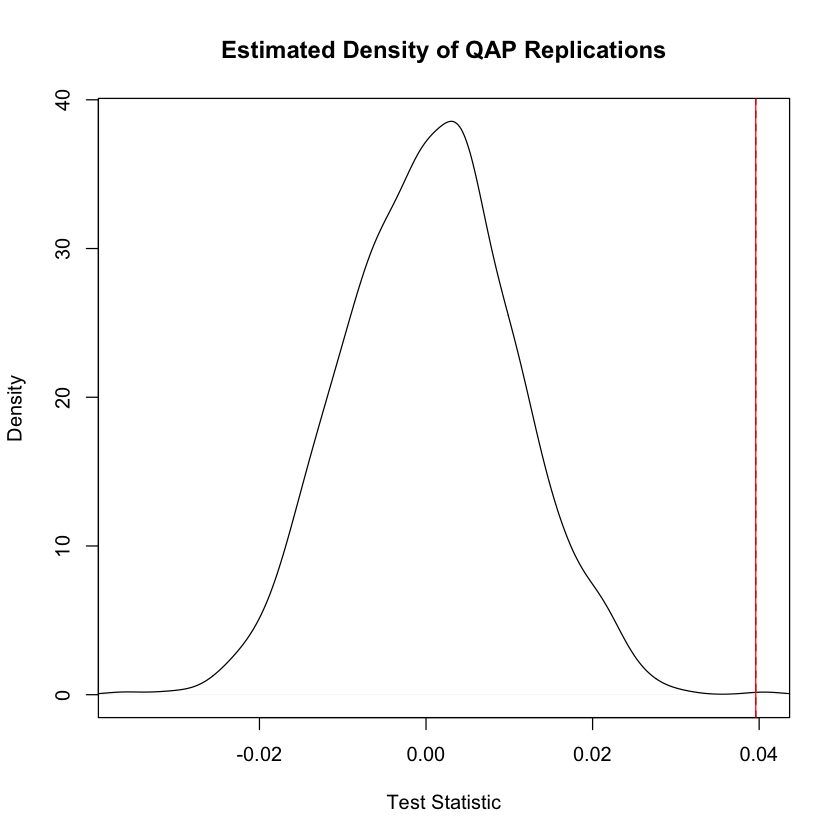

In [50]:
execute_qaptest(adj_matrix, dist_matrix)

### Checking the effect of colonization specifically in case of Great Britain

In [51]:
observed_statistic_exports_col = sum(nodes$exports[nodes$colonizer == 'GBR'])
observed_statistic_imports_col = sum(nodes$imports[nodes$colonizer == 'GBR'])

In [52]:
permutation_matrix_col = matrix(0, nrow = n, ncol = N)
for (i in 1:N) {
    permutation_matrix_col[, i] = sample(nodes$colonizer, size = n, replace = F)
}

In [53]:
permutated_statistic_exports_col = matrix(0, nrow=N, ncol=1)
permutated_statistic_imports_col = matrix(0, nrow=N, ncol=1)
for (i in 1:N) {
    permutated_statistic_exports_col[i,] = sum(nodes$exports[permutation_matrix_col[,i] == 'GBR'])
    permutated_statistic_imports_col[i,] = sum(nodes$imports[permutation_matrix_col[,i] == 'GBR'])
}

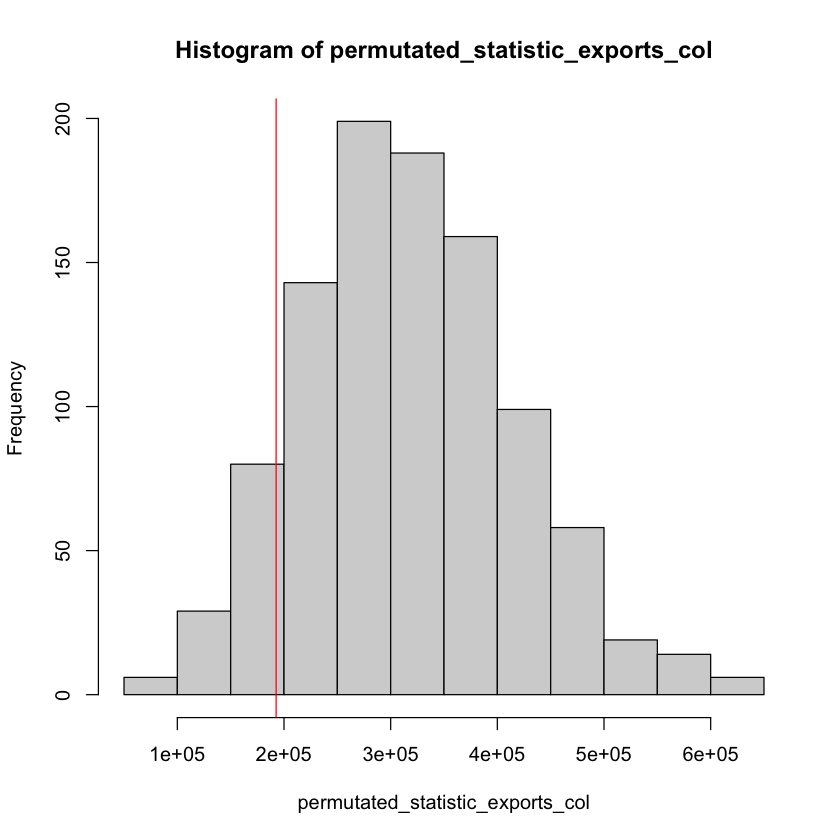

In [54]:
par(bg = 'white')
hist(permutated_statistic_exports_col)
abline(v=observed_statistic_exports_col, col='red')

In [55]:
mean(permutated_statistic_exports_col < observed_statistic_exports_col)

[1] 0.104

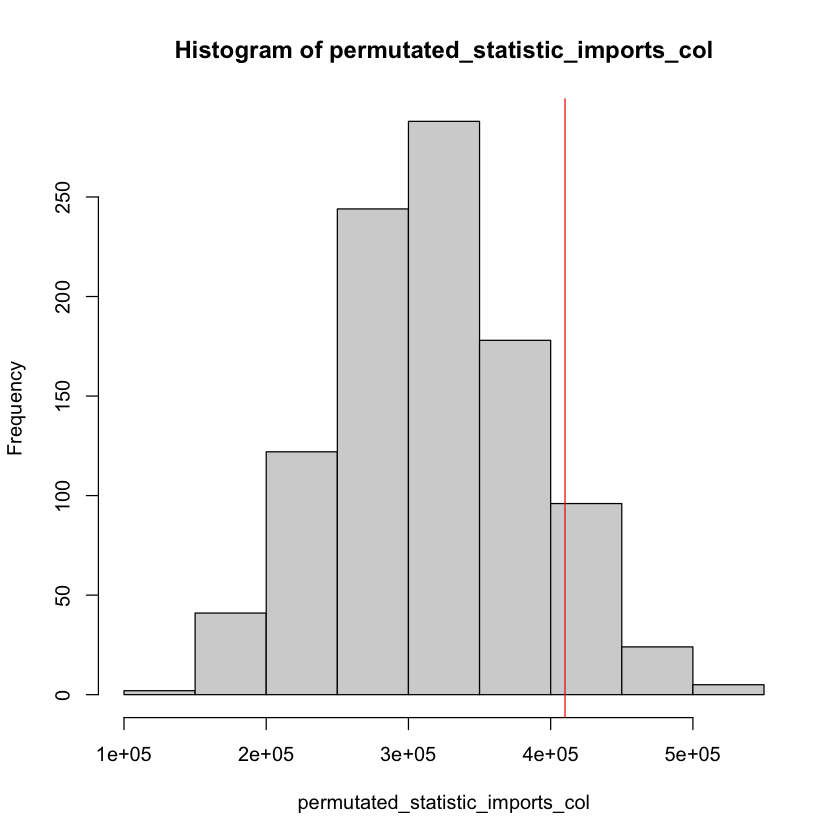

In [56]:
par(bg = 'white')
hist(permutated_statistic_imports_col)
abline(v=observed_statistic_imports_col, col='red')

In [57]:
mean(permutated_statistic_imports_col < observed_statistic_imports_col)

[1] 0.905

### Examining the effect of homophily on the network of trades

In [58]:
count_homophily = function(edges, nodes, attrs, ...) {
    count = 0
    for (i in 1:dim(edges)[1]) {
        if (attrs[nodes$country_iso3 == edges$source[i]] == attrs[nodes$country_iso3 == edges$target[i]]) {
            count = count + 1
        }
    }
    return(count)
}

In [59]:
execute_permutation_test = function(edges, nodes, func, attrs, attr, ...) {
    params = list(...)
    observed_statistic = func(edges, nodes, attrs, params)

    
#     generating new samples by permutating the attributes
    permutated_samples = matrix(0, nrow = n, ncol = N)
    for (i in 1:N) {
        permutated_samples[, i] = sample(x = attrs, size = n, replace = F)
    }
    
#    computing the specified statistic for all the permutated networks
    permutated_statistics = matrix(0, nrow = N, ncol = 1)
    for (j in 1:N) {
        permutated_statistics[j] = func(edges, nodes, permutated_samples[, j], params)
    }
    
    p_value = mean(permutated_statistics < observed_statistic)
    if (p_value > .5) {
        p_value = 1 - p_value
    }
    
    print(paste(attr, ',', p_value))
    pdf(paste('../results/', attr, '.pdf'))
    par(bg = 'white')
    hist(
        permutated_statistics, 
        xlim=c(min(min(permutated_statistics), observed_statistic), max(max(permutated_statistics), observed_statistic)), 
        main = paste('Comparison of the observed statistic and \npermutated ones with respect to \n', attr, 'with p-value: ', p_value)
    )
    abline(v=observed_statistic, col='red')
    
    dev.off()
}

In [60]:
categories = !unlist(lapply(nodes, FUN = is.numeric))
categories[attr(categories, 'names') == 'country_iso3'] = FALSE
categories = colnames(nodes[, categories])

In [61]:
for (col in categories) {
    execute_permutation_test(edges, nodes, count_homophily, nodes[, col], paste('homophily ', as.character(col)))
}

[1] "homophily  continent , 0"
[1] "homophily  landlocked , 0"
[1] "homophily  colonizer , 0.069"
[1] "homophily  langoff_1 , 0.002"


### Examining the effect of closeness

In [62]:
compute_nodecov = function(edges, nodes, attrs, ...) {
#     log transformation parameter
    params = list(...)
    sum = 0
    for (i in 1:dim(edges)[1]) {
        if (as.logical(params[[1]])) {
            sum = sum + log(attrs[nodes$country_iso3 == edges$source[i]] + attrs[nodes$country_iso3 == edges$target[i]])
        } else {
            sum = sum + attrs[nodes$country_iso3 == edges$source[i]] + attrs[nodes$country_iso3 == edges$target[i]]
        }
    }
    return(sum)
}

In [63]:
compute_absdiff = function(edges, nodes, attrs, ...) {
#     log transformation parameter
    params = list(...)
    diff_sum = 0
    for (i in 1:dim(edges)[1]) {
        if (as.logical(params[[1]])) {
            diff_sum = diff_sum + log(1 + abs(attrs[nodes$country_iso3 == edges$source[i]] - attrs[nodes$country_iso3 == edges$target[i]]))
        } else {
            diff_sum = diff_sum + abs(attrs[nodes$country_iso3 == edges$source[i]] - attrs[nodes$country_iso3 == edges$target[i]])
        }
    }
    return(diff_sum)
}

In [64]:
nums <- unlist(lapply(nodes, is.numeric))
nums = colnames(nodes[, nums])

In [65]:
for (col in nums) {
    execute_permutation_test(edges, nodes, compute_nodecov, nodes[, col], paste('nodecov ', as.character(col)), FALSE)
    execute_permutation_test(edges, nodes, compute_absdiff, nodes[, col], paste('absdiff ', as.character(col)), FALSE)
}

[1] "nodecov  merchandise_of_gdp , 0.445"
[1] "absdiff  merchandise_of_gdp , 0.23"
[1] "nodecov  area , 0.006"
[1] "absdiff  area , 0.006"
[1] "nodecov  population , 0"
[1] "absdiff  population , 0"
[1] "nodecov  industry_of_gdp , 0.498"
[1] "absdiff  industry_of_gdp , 0.491"
[1] "nodecov  agriculture_forestry_fishing_of_gdp , 0.001"
[1] "absdiff  agriculture_forestry_fishing_of_gdp , 0"
[1] "nodecov  life_expectancy , 0"
[1] "absdiff  life_expectancy , 0"
[1] "nodecov  net_barter_of_trade , 0.045"
[1] "absdiff  net_barter_of_trade , 0.256"
[1] "nodecov  inflation_rate , 0.301"
[1] "absdiff  inflation_rate , 0.29"
[1] "nodecov  gni_atlas , 0"
[1] "absdiff  gni_atlas , 0"
[1] "nodecov  foreign_direct_investment_inflows , 0"
[1] "absdiff  foreign_direct_investment_inflows , 0"
[1] "nodecov  happiness , 0.251"
[1] "absdiff  happiness , 0.119"
[1] "nodecov  gdp_us_dollar , 0"
[1] "absdiff  gdp_us_dollar , 0"
[1] "nodecov  gdp_growth , 0.073"
[1] "absdiff  gdp_growth , 0.169"
[1] "nodecov  

### Transform numerical data to categorical and do homophily test

In [66]:
for (col in nums) {
    values = nodes[, col]
    breaks <- c(quantile(values)[1] - 1, quantile(values)[2], quantile(values)[4], quantile(values)[5] + 1)
    tags <- c("Low", "Medium", "High")
    execute_permutation_test(edges, nodes, count_homophily, cut(values, breaks = breaks, labels = tags), paste('homophily ', as.character(col)))
}

[1] "homophily  merchandise_of_gdp , 0.374"
[1] "homophily  area , 0.251"
[1] "homophily  population , 0.289"
[1] "homophily  industry_of_gdp , 0.287"
[1] "homophily  agriculture_forestry_fishing_of_gdp , 0.039"
[1] "homophily  life_expectancy , 0"
[1] "homophily  net_barter_of_trade , 0.229"
[1] "homophily  inflation_rate , 0.302"
[1] "homophily  gni_atlas , 0.246"
[1] "homophily  foreign_direct_investment_inflows , 0.307"
[1] "homophily  happiness , 0.087"
[1] "homophily  gdp_us_dollar , 0.396"
[1] "homophily  gdp_growth , 0.416"
[1] "homophily  gdp_per_capita , 0.049"
[1] "homophily  exports , 0.087"
[1] "homophily  imports , 0.098"


### Statistics that take into account the structure of the network

In [12]:
nodes

country_iso3,merchandise_of_gdp,area,population,industry_of_gdp,continent,agriculture_forestry_fishing_of_gdp,life_expectancy,landlocked,colonizer,net_barter_of_trade,inflation_rate,langoff_1,gni_atlas,foreign_direct_investment_inflows,happiness,gdp_us_dollar,gdp_growth,gdp_per_capita
<chr>,<dbl>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AFG,38.70415,652225,30117411,22.74025,Asia,23.7436640,61.55300,TRUE,USA,144.75187,11.8041858,Persian,1.607712e+10,52173421,0.721,1.780429e+10,0.4263548,591.1628
AGO,78.30597,1246700,24220660,56.02651,Africa,5.8456810,56.33000,FALSE,PRT,244.32915,13.4824679,Portuguese,8.260603e+10,-3023770966,0.708,1.117897e+11,3.4719763,4615.4682
ALB,56.86241,28748,2905195,24.48441,Europe,18.2267654,76.91400,FALSE,NONE,94.33720,3.4291232,Albanian,1.280372e+10,1048706682,0.568,1.289077e+10,2.5453218,4437.1429
ARE,151.70246,83657,8946778,58.03560,Asia,0.6719101,76.52100,FALSE,GBR,176.14978,0.8773466,Arabic,3.133841e+11,7152095826,0.764,3.506660e+11,6.9302716,39194.6722
ARG,29.87193,2766889,41261490,25.21270,America,6.9987338,75.43900,FALSE,NONE,160.56492,9.8000000,Spanish,4.421068e+11,10839930945,0.813,5.301633e+11,6.0039517,12848.8642
ARM,54.02228,29800,2876536,27.50000,Asia,17.5000000,73.57200,TRUE,NONE,128.24335,7.6500081,Armenian,1.016034e+10,653219756,0.488,1.014211e+10,4.7000000,3525.8072
AUS,36.90503,7686848,22340024,26.43613,Pacific,2.2765424,81.89512,FALSE,NONE,200.28858,3.3038502,English,1.124160e+12,65554890650,0.863,1.396650e+12,2.4627563,62517.8337
AUT,85.55500,83858,8391643,25.44743,Europe,1.4019149,80.98293,TRUE,NONE,88.72963,3.2865791,German,4.245458e+11,22983942932,0.890,4.311203e+11,2.9227973,51374.9584
AZE,67.71781,86600,9173082,61.73400,Asia,5.0762260,71.23400,TRUE,NONE,199.30369,7.8583333,Azeri,5.010686e+10,4485120000,0.455,6.595163e+10,-1.5729976,7189.6912
